In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Configuração para os gráficos
plt.rcParams['figure.figsize'] = [14, 8]

In [7]:
# Constantes de Cor
RED = 1
BLACK = 0

class NodeRB:
    def __init__(self, data, color=RED):
        self.data = data
        self.color = color
        self.parent = None
        self.left = None
        self.right = None
        self.count = 1  # Contador de repetidos

class RedBlackTree:
    def __init__(self):
        # O nó sentinela (NIL) representa as folhas nulas e é sempre PRETO
        self.TNULL = NodeRB(None, color=BLACK)
        self.TNULL.left = None
        self.TNULL.right = None
        self.root = self.TNULL

    # --- ROTAÇÕES (Para corrigir o balanceamento) ---
    def left_rotate(self, x):
        y = x.right
        x.right = y.left
        if y.left != self.TNULL:
            y.left.parent = x
        y.parent = x.parent
        if x.parent is None:
            self.root = y
        elif x == x.parent.left:
            x.parent.left = y
        else:
            x.parent.right = y
        y.left = x
        x.parent = y

    def right_rotate(self, x):
        y = x.left
        x.left = y.right
        if y.right != self.TNULL:
            y.right.parent = x
        y.parent = x.parent
        if x.parent is None:
            self.root = y
        elif x == x.parent.right:
            x.parent.right = y
        else:
            x.parent.left = y
        y.right = x
        x.parent = y

    # --- BUSCA ---
    def search(self, k):
        """Busca uma chave k e retorna o nó se encontrar, ou None."""
        current = self.root
        while current != self.TNULL:
            if k == current.data:
                return current # Encontrou! Retorna o objeto Nó
            elif k < current.data:
                current = current.left
            else:
                current = current.right
        return None # Não encontrou

    # --- INSERÇÃO ---
    def insert(self, key):
        # 1. Inserção normal de BST
        node = NodeRB(key)
        node.parent = None
        node.data = key
        node.left = self.TNULL
        node.right = self.TNULL
        node.color = RED  # Todo novo nó nasce VERMELHO

        y = None
        x = self.root

        while x != self.TNULL:
            y = x
            if key == x.data:
                # Se já existe, apenas incrementa contador e para
                x.count += 1
                return
            elif key < x.data:
                x = x.left
            else:
                x = x.right

        node.parent = y
        if y is None:
            self.root = node
        elif key < y.data:
            y.left = node
        else:
            y.right = node

        # 2. Correção das cores e rotações se necessário
        if node.parent is None:
            node.color = BLACK
            return

        if node.parent.parent is None:
            return

        self.fix_insert(node)

    # --- CORREÇÃO PÓS-INSERÇÃO ---
    def fix_insert(self, k):
        while k.parent.color == RED:
            if k.parent == k.parent.parent.right:
                u = k.parent.parent.left  # Tio
                if u.color == RED:
                    # Caso 1: Tio Vermelho -> Recolorir
                    u.color = BLACK
                    k.parent.color = BLACK
                    k.parent.parent.color = RED
                    k = k.parent.parent
                else:
                    if k == k.parent.left:
                        # Caso 2: Tio Preto e Triângulo -> Rotação Dupla
                        k = k.parent
                        self.right_rotate(k)
                    # Caso 3: Tio Preto e Linha -> Rotação Simples + Recolorir
                    k.parent.color = BLACK
                    k.parent.parent.color = RED
                    self.left_rotate(k.parent.parent)
            else:
                u = k.parent.parent.right  # Tio
                if u.color == RED:
                    # Caso 1
                    u.color = BLACK
                    k.parent.color = BLACK
                    k.parent.parent.color = RED
                    k = k.parent.parent
                else:
                    if k == k.parent.right:
                        # Caso 2
                        k = k.parent
                        self.left_rotate(k)
                    # Caso 3
                    k.parent.color = BLACK
                    k.parent.parent.color = RED
                    self.right_rotate(k.parent.parent)
            if k == self.root:
                break
        self.root.color = BLACK

In [8]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    """Calcula posições para o desenho ficar igual árvore"""
    if not nx.is_tree(G): return nx.spring_layout(G)
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos=None, parent=None):
        if pos is None: pos = {root: (xcenter, vert_loc)}
        else: pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None: children.remove(parent)  
        if len(children) != 0:
            dx = width / len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def draw_rb_tree(tree):
    G = nx.DiGraph()
    labels = {}
    node_colors = []
    ids = {} # Mapa para guardar a cor de cada ID
    
    # Função auxiliar para percorrer e montar o grafo
    def add_edges(node):
        if node == tree.TNULL: return
        
        node_id = id(node)
        
        # Label com contador: "10(x2)"
        lbl = str(node.data)
        if node.count > 1:
            lbl += f"(x{node.count})"
        labels[node_id] = lbl
        
        # Guarda a cor para usar no desenho depois
        # Vermelho vivo ou Preto (Cinza Escuro para ler o texto)
        ids[node_id] = "#FF4444" if node.color == 1 else "#555555" 
        
        G.add_node(node_id)
        
        if node.left != tree.TNULL:
            G.add_edge(node_id, id(node.left))
            add_edges(node.left)
        if node.right != tree.TNULL:
            G.add_edge(node_id, id(node.right))
            add_edges(node.right)
            
    if tree.root == tree.TNULL:
        print("Árvore Vazia")
        return

    add_edges(tree.root)
    
    # Lista de cores na ordem que o NetworkX precisa
    colors = [ids[node] for node in G.nodes()]
    
    try: pos = hierarchy_pos(G, id(tree.root))
    except: pos = nx.spring_layout(G)
    
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, with_labels=False, node_size=2500, node_color=colors, edge_color="gray", arrows=True)
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold", font_color="white")
    plt.title("Visualização da Árvore Rubro-Negra (Red-Black Tree)")
    plt.show()

Inserindo: [10, 20, 30, 40, 50, 60, 70, 80, 20, 10, 35, 25]

--- Resultado Final ---


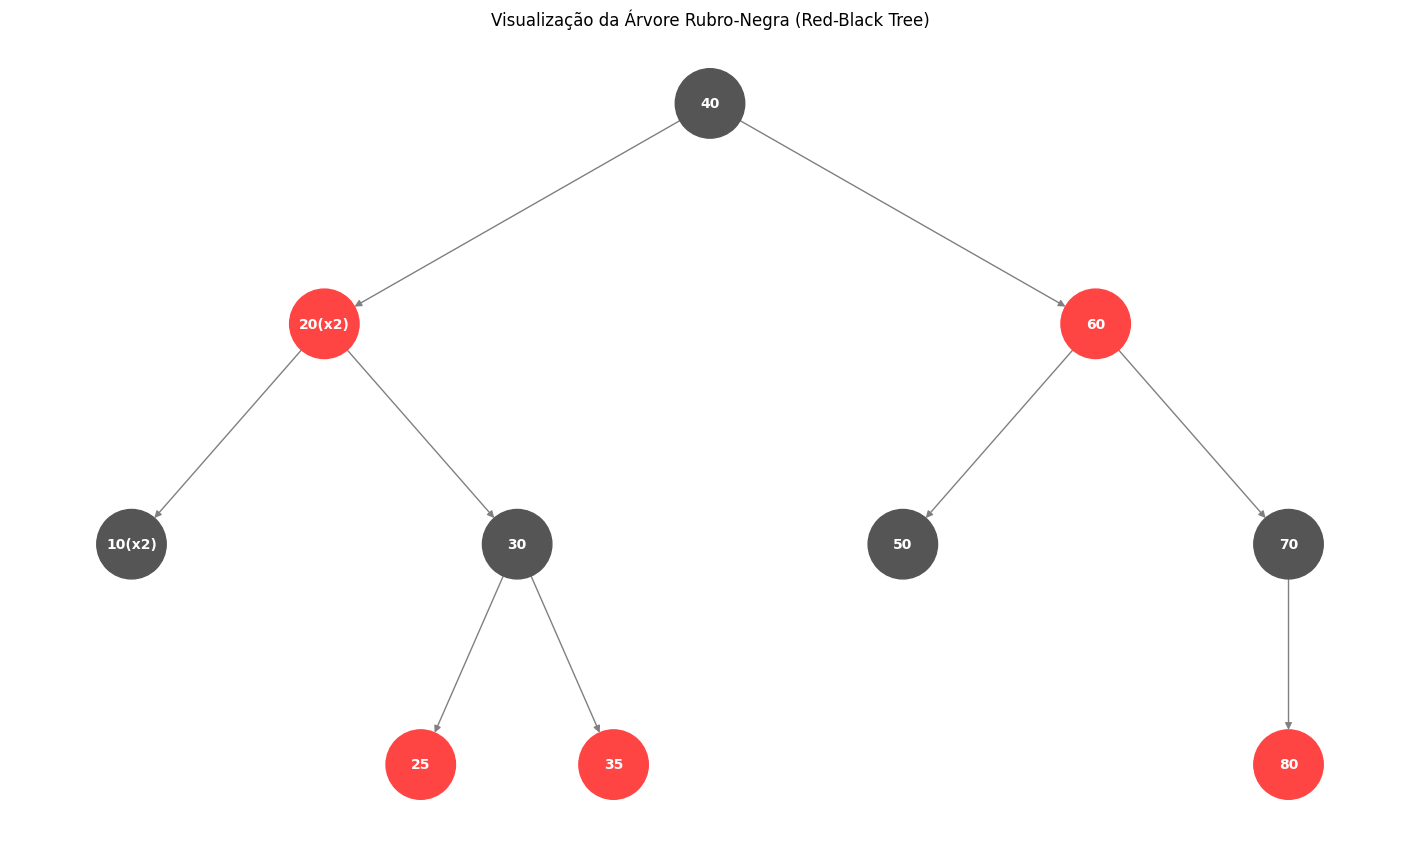

In [9]:
rb = RedBlackTree()

# Inserindo dados de teste
# Incluindo repetidos para testar o contador
dados = [10, 20, 30, 40, 50, 60, 70, 80, 20, 10, 35, 25]

print(f"Inserindo: {dados}")
for val in dados:
    rb.insert(val)

print("\n--- Resultado Final ---")
draw_rb_tree(rb)

In [10]:
# ... código de inserção anterior ...

# TESTE DE BUSCA
print("\n--- Testando a Busca ---")
valores_teste = [40, 999] # 40 existe, 999 não

for v in valores_teste:
    resultado = rb.search(v)
    if resultado:
        print(f"Valor {v} encontrado! (Cor: {'Vermelho' if resultado.color == 1 else 'Preto'})")
    else:
        print(f"Valor {v} NÃO encontrado.")


--- Testando a Busca ---
Valor 40 encontrado! (Cor: Preto)
Valor 999 NÃO encontrado.
